In [1]:
from pathlib import Path
from IPython.display import HTML, display

css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))


# فصل ۳ — تحلیل اکتشافی داده‌ها (EDA)
## درس ۱: مصورسازی توزیع‌های داده


### آنچه در این درس یاد می‌گیرید

در پایان این درس می‌توانید:

- توضیح دهید «توزیع داده» چیست و چرا در تحلیل اکتشافی داده‌ها (EDA) و انتخاب مدل نقش بنیادی دارد.
- توزیع‌های عددی را با هیستوگرام، برآورد چگالی کرنلی (KDE)، تابع توزیع تجمعی تجربی (ECDF) و نمودارهای Q–Q مصورسازی کنید.
- توزیع‌های رده‌ای/کیفی را با نمودار میله‌ای، میله‌های انباشته/نسبتی و جدول‌های توافقی نمایش دهید.
- توزیع‌ها را بین گروه‌ها مقایسه کنید (مثلاً بر اساس برچسب کلاس) با نمودارهای facet، نمودار جعبه‌ای و ویولن، و چگالی‌های هم‌پوشان.
- برای پهنای بین‌ها در هیستوگرام و پارامترهای هموارسازی در KDE، انتخاب‌های اصولی داشته باشید.
- مشکلات توزیعی رایج که پایپ‌لاین‌های یادگیری ماشین را مختل می‌کنند تشخیص دهید: دنباله‌های سنگین، چولگی، نقاط پرت و تغییر توزیع بین اسپیلیت‌ها.

در طول درس، از چند دیتاست مختلف در همین مخزن استفاده می‌کنیم تا انواع توزیع را ببینید:
داده‌های پیوسته، گسسته، رده‌ای و ترکیبی.


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# استفاده از Seaborn اختیاری است؛ نوت‌بوک بدون آن هم اجرا می‌شود.
try:
    import seaborn as sns
    _HAS_SEABORN = True
except Exception:
    _HAS_SEABORN = False

# SciPy اختیاری است و برای Q–Q و برخی آزمون‌ها مفید است.
try:
    from scipy import stats
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

from pathlib import Path


In [3]:
def read_csv_rel(rel_path: str) -> pd.DataFrame:
    """خواندن CSV با مسیر نسبی (نسبت به پوشه همین نوت‌بوک)."""
    p = Path(rel_path)
    if not p.exists():
        raise FileNotFoundError(
            f"فایل پیدا نشد: {p.resolve()}\n"
            "این نوت‌بوک را از داخل مخزن (repository) کلون‌شده اجرا کنید."
        )
    return pd.read_csv(p)

def quick_overview(df: pd.DataFrame, name: str = "DataFrame", n: int = 5) -> None:
    print(f"{name}: shape={df.shape}")
    display(df.head(n))
    print("\nنوع ستون‌ها:")
    display(df.dtypes.to_frame("dtype"))
    print("\nمقدار گمشده (%):")
    miss = (df.isna().mean() * 100).sort_values(ascending=False)
    display(miss.to_frame("missing_%").head(20))

def set_plot_style():
    plt.rcParams.update({
        "figure.figsize": (9, 5),
        "axes.grid": True,
        "grid.alpha": 0.25,
        "axes.spines.top": False,
        "axes.spines.right": False,
    })

set_plot_style()


In [4]:
def freedman_diaconis_bins(x) -> int:
    """Return a reasonable number of histogram bins using the Freedman–Diaconis rule.

    Accepts a pandas Series, NumPy array, or any 1D array-like. Non-numeric values are coerced to NaN.
    """
    x = pd.Series(np.asarray(x).ravel())
    x = pd.to_numeric(x, errors="coerce").dropna().to_numpy()
    n = x.size
    if n < 2:
        return 10

    q75, q25 = np.percentile(x, [75, 25])
    iqr = q75 - q25

    # If IQR is zero (many repeated values), fall back to sqrt(n) rule of thumb.
    if iqr <= 0:
        return max(5, min(int(np.ceil(np.sqrt(n))), 200))

    bin_width = 2 * iqr / (n ** (1 / 3))
    if bin_width <= 0:
        return max(5, min(int(np.ceil(np.sqrt(n))), 200))

    data_range = x.max() - x.min()
    if data_range <= 0:
        return max(5, min(int(np.ceil(np.sqrt(n))), 200))

    bins = int(np.ceil(data_range / bin_width))
    return max(5, min(bins, 200))
def ecdf(x: pd.Series):
    x = pd.to_numeric(x, errors="coerce").dropna().to_numpy()
    x = np.sort(x)
    y = np.arange(1, x.size + 1) / x.size
    return x, y

def overlay_hist(ax, series_list, labels, bins=30, density=True, alpha=0.35):
    for s, lab in zip(series_list, labels):
        arr = pd.to_numeric(s, errors="coerce").dropna().to_numpy()
        ax.hist(arr, bins=bins, density=density, alpha=alpha, label=lab)
    ax.legend()



### ۱) چرا «توزیع» اولین شیء در EDA است؟

یک دیتاست فقط مجموعه‌ای از سطرها نیست؛ بلکه نمونه‌ای از یک فرآیند تولید داده (ناشناخته) است.
هدف EDA این است که *پیش از مدل‌سازی* تا حد ممکن آن فرآیند را توصیف کند.

توزیع به پرسش‌هایی مانند پاسخ می‌دهد:

- **جرم کجا متمرکز است؟** مقادیر معمول (مکان).
- **پراکندگی چقدر است؟** تغییرپذیری (مقیاس).
- **تقارن دارد یا نه؟** چولگی و دنباله‌های سنگین.
- **چند رژیم/بخش دارد؟** چندقله‌ای بودن (Mixture / Segment).
- **آیا رویدادهای نادر اما شدید داریم؟** نقاط پرت و ریسک دنباله.
- **بین گروه‌ها یا زمان تغییر می‌کند؟** توزیع شرطی و رانش (drift).

بسیاری از شکست‌های یادگیری ماشین، شکست‌های توزیعی هستند:

- مدل خطی بد عمل می‌کند چون پاسخ دنباله‌سنگین است و واریانس را چند مقدار نادر کنترل می‌کنند.
- یک طبقه‌بند فرو می‌ریزد چون توزیع یک ویژگی در محیط تولید با آموزش فرق دارد (covariate shift).
- یک پایپ‌لاین دچار leakage می‌شود چون یک ویژگی «پس از وقوع نتیجه» جدایی غیرطبیعی در توزیع ایجاد می‌کند.

یک مدل ذهنی مفید این است: $x_1, x_2, \ldots, x_n$ را به‌عنوان نمونه‌های i.i.d. از توزیعی با
چگالی $f(x)$ (یا تابع جرم احتمال برای داده‌های گسسته) مشاهده می‌کنید.
از این نمونه‌ها، برآوردگرهایی برای کمیت‌های توزیعی می‌سازید.

دو برآوردگر پایه:

- **تابع توزیع تجربی** (ECDF):
  $$
  \hat F_n(x) = \frac{1}{n}\sum_{i=1}^n \mathbf{1}\{x_i \le x\}.
  $$
- **میانگین و واریانس نمونه**:
  $$
  \bar x = \frac{1}{n}\sum_{i=1}^n x_i, \qquad
  s^2 = \frac{1}{n-1}\sum_{i=1}^n (x_i-\bar x)^2.
  $$

اما آمارهای خلاصه کافی نیستند. دو توزیع بسیار متفاوت می‌توانند میانگین و واریانس یکسان داشته باشند.
مصورسازی به شما اجازه می‌دهد *شکل* را ببینید.



### ۲) هیستوگرام به‌عنوان برآوردگر چگالی (و انتخاب بین‌ها)

هیستوگرام فقط یک تصویر نیست؛ یک **برآوردگر چگالی ناپارامتری** است.

اگر پهنای بین را $h > 0$ بگیریم، و بازه $B_j = [a + (j-1)h,\ a + jh)$،
برآورد چگالی هیستوگرام چنین نوشته می‌شود:
$$
\hat f_h(x) = \frac{1}{nh}\sum_{i=1}^n \mathbf{1}\{x_i \in B_j\} \quad \text{برای } x \in B_j.
$$

انتخاب $h$ یک مبادله بایاس–واریانس ایجاد می‌کند:

- **$h$ خیلی کوچک**: واریانس بالا، هیستوگرام پرنویز.
- **$h$ خیلی بزرگ**: بایاس بالا، ساختارهای مهم صاف می‌شوند.

دو قاعده کلاسیک و داده‌محور برای $h$:

1) **قاعده اسکات** (بر مبنای انحراف معیار):
$$
h_{\text{Scott}} = \frac{3.5\,s}{n^{1/3}}.
$$

2) **قاعده فریدمن–دیاکونیس** (بر مبنای IQR و مقاوم‌تر):
$$
h_{\text{FD}} = \frac{2\,\text{IQR}}{n^{1/3}},
\qquad \text{IQR} = Q_{0.75} - Q_{0.25}.
$$

در عمل، این قواعد نقطه شروع هستند.
در EDA برای ML، بهتر است حساسیت را هم بررسی کنید:
اگر نتیجه‌گیری شما با تغییر $h$ به‌شدت عوض می‌شود، خودِ این موضوع یک سیگنال است.


In [5]:
# دیتاست ۱ (رگرسیون): diamonds
diamonds_path = "../../../Datasets/Regression/diamonds.csv"
diamonds = read_csv_rel(diamonds_path)

quick_overview(diamonds, name="diamonds")


diamonds: shape=(53940, 11)


,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75



نوع ستون‌ها:


,dtype
id,int64
carat,float64
cut,object
color,object
clarity,object
depth,float64
table,float64
price,int64
x,float64
y,float64



مقدار گمشده (%):


,missing_%
id,0.0
carat,0.0
cut,0.0
color,0.0
clarity,0.0
depth,0.0
table,0.0
price,0.0
x,0.0
y,0.0


خلاصه price:


,price
count,53940.000000
mean,3932.799722
std,3989.439738
min,326.000000
1%,429.000000
5%,544.000000
25%,950.000000
50%,2401.000000
75%,5324.250000
95%,13107.100000


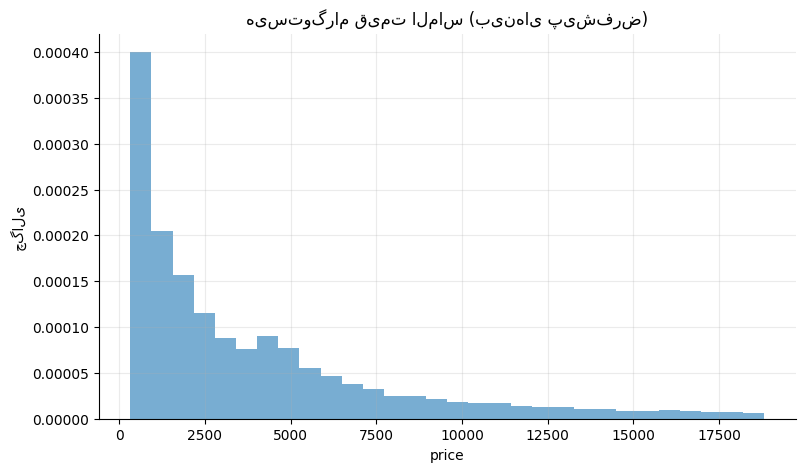

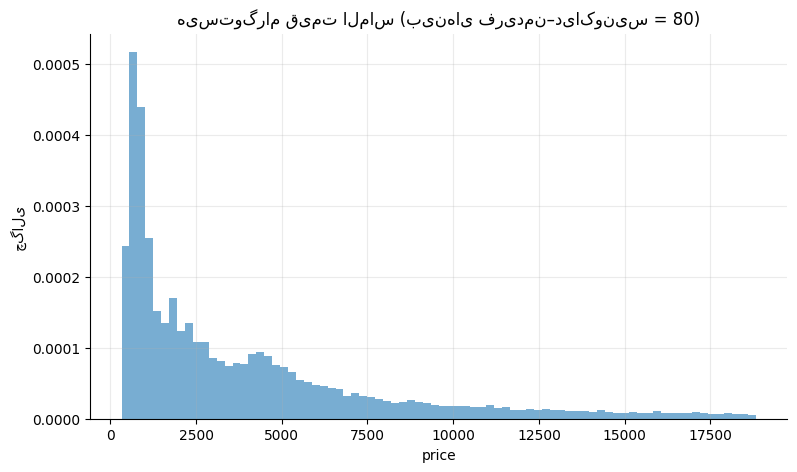

In [6]:
# متغیر تمرکز: price (عددی و معمولاً دنباله‌سنگین)
price = pd.to_numeric(diamonds["price"], errors="coerce").dropna()

print("خلاصه price:")
display(price.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).to_frame("price"))

bins_default = 30
bins_fd = freedman_diaconis_bins(price)

fig, ax = plt.subplots()
ax.hist(price, bins=bins_default, density=True, alpha=0.6)
ax.set_title("هیستوگرام قیمت الماس (بین‌های پیش‌فرض)")
ax.set_xlabel("price")
ax.set_ylabel("چگالی")
plt.show()

fig, ax = plt.subplots()
ax.hist(price, bins=bins_fd, density=True, alpha=0.6)
ax.set_title(f"هیستوگرام قیمت الماس (بین‌های فریدمن–دیاکونیس = {bins_fd})")
ax.set_xlabel("price")
ax.set_ylabel("چگالی")
plt.show()


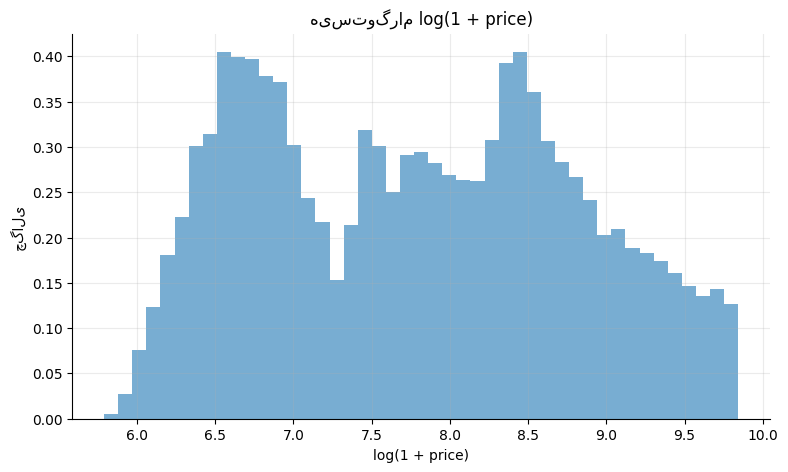

خلاصه log(1 + price):


,log1p(price)
count,53940.000000
mean,7.787424
std,1.014111
min,5.789960
25%,6.857514
50%,7.784057
75%,8.580215
max,9.842888


In [7]:
# دنباله‌های سنگین معمولاً در مقیاس لگاریتمی خواناتر می‌شوند.
# (از log1p استفاده می‌کنیم تا با صفر هم سازگار باشد.)
log_price = np.log1p(price)

fig, ax = plt.subplots()
ax.hist(log_price, bins=freedman_diaconis_bins(log_price), density=True, alpha=0.6)
ax.set_title("هیستوگرام log(1 + price)")
ax.set_xlabel("log(1 + price)")
ax.set_ylabel("چگالی")
plt.show()

print("خلاصه log(1 + price):")
display(pd.Series(log_price).describe().to_frame("log1p(price)"))



### ۳) KDE: برآورد هموار توزیع

KDE چگالی را با قرار دادن یک کرنل $K$ روی هر نقطه داده و میانگین‌گیری برآورد می‌کند:
$$
\hat f_h(x) = \frac{1}{nh}\sum_{i=1}^n K\!\left(\frac{x-x_i}{h}\right).
$$

برای کرنل گاوسی:
$$
K(u) = \frac{1}{\sqrt{2\pi}} e^{-u^2/2}.
$$

تعبیر:

- $h$ همان **پهنای باند** است. $h$ بزرگ‌تر یعنی هموارسازی بیشتر.
- KDE برای مقایسه چند گروه، اغلب از هیستوگرام خواناتر است.

نکات احتیاطی در EDA:

- اگر داده‌ها ذاتاً گسسته/صحیح باشند، KDE ممکن است ساختار گسسته را پنهان کند.
- نزدیک مرزها (مثلاً داده‌های مثبت)، KDE می‌تواند بایاس داشته باشد.
- برای $n$ خیلی بزرگ، محاسبه KDE می‌تواند پرهزینه باشد (هرچند تقریب‌های سریع وجود دارد).

KDE مکمل هیستوگرام است، نه جایگزین کامل آن.


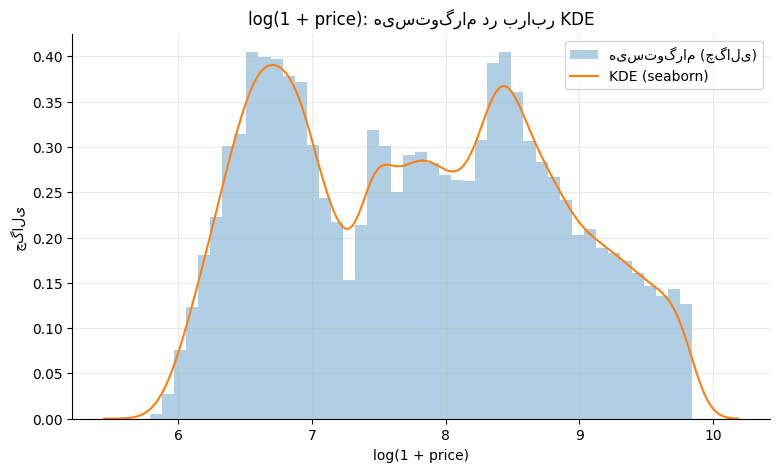

In [8]:
# KDE: مقایسه هیستوگرام با KDE
fig, ax = plt.subplots()
ax.hist(log_price, bins=freedman_diaconis_bins(log_price), density=True, alpha=0.35, label="هیستوگرام (چگالی)")
if _HAS_SEABORN:
    sns.kdeplot(log_price, ax=ax, label="KDE (seaborn)")
ax.set_title("log(1 + price): هیستوگرام در برابر KDE")
ax.set_xlabel("log(1 + price)")
ax.set_ylabel("چگالی")
ax.legend()
plt.show()



### ۴) ECDF و Q–Q: شکل توزیع بدون بین‌بندی

**ECDF** نه بین دارد و نه پهنای باند. یک تابع پله‌ای است که جرم را تجمع می‌دهد.
دو مزیت کلیدی:

- پایدار است: انتخاب‌های نمایشی کوچک، شکل را خیلی تغییر نمی‌دهند.
- مقایسه گروه‌ها با هم‌پوشانی چند ECDF آسان است.

**نمودار Q–Q** کوانتایل‌های نمونه را با کوانتایل‌های یک توزیع مرجع مقایسه می‌کند.
برای Q–Q نرمال:
- محور $x$: کوانتایل‌های نظری نرمال،
- محور $y$: کوانتایل‌های نمونه.

اگر داده تقریباً نرمال باشد، نقاط نزدیک یک خط راست می‌افتند.
خمیدگی سیستماتیک نشان‌دهنده چولگی یا دنباله‌های سنگین است.

در ML از Q–Q عمدتاً برای این موارد استفاده می‌شود:
- بررسی اینکه یک تبدیل (مثلاً $\log$) توزیع را متقارن‌تر می‌کند یا نه،
- تشخیص اهداف دنباله‌سنگین که می‌توانند توابع خطای رگرسیون را ناپایدار کنند.


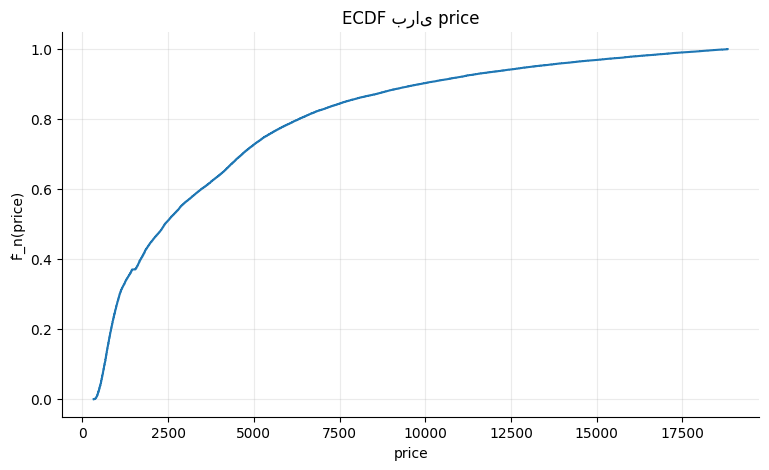

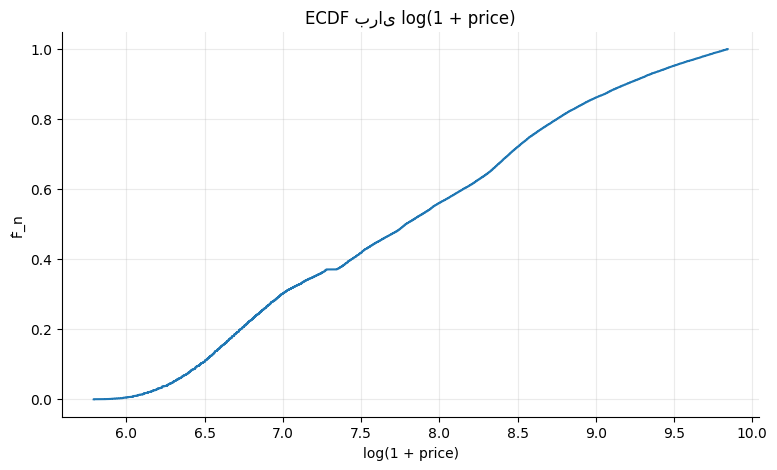

In [9]:
# ECDF: نمای تجمعی توزیع
x_ecdf, y_ecdf = ecdf(price)

fig, ax = plt.subplots()
ax.step(x_ecdf, y_ecdf, where="post")
ax.set_title("ECDF برای price")
ax.set_xlabel("price")
ax.set_ylabel("F̂_n(price)")
plt.show()

# ECDF در مقیاس لگاریتمی هم می‌تواند برای دنباله‌های سنگین مفید باشد
x_ecdf_l, y_ecdf_l = ecdf(log_price)
fig, ax = plt.subplots()
ax.step(x_ecdf_l, y_ecdf_l, where="post")
ax.set_title("ECDF برای log(1 + price)")
ax.set_xlabel("log(1 + price)")
ax.set_ylabel("F̂_n")
plt.show()


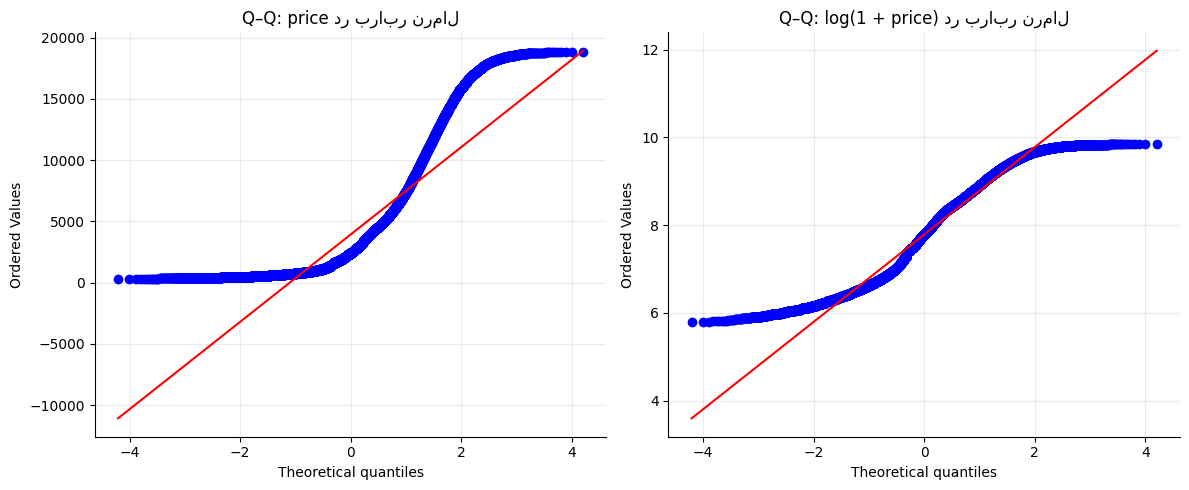

In [10]:
# نمودار Q–Q: آیا log(1 + price) به نرمال نزدیک‌تر از price است؟
def qq_plot(ax, x: np.ndarray, title: str):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    if x.size < 5:
        ax.text(0.5, 0.5, "داده کافی نیست", ha="center", va="center")
        ax.set_title(title)
        return
    if _HAS_SCIPY:
        stats.probplot(x, dist="norm", plot=ax)
        ax.set_title(title)
    else:
        # Q–Q حداقلی بدون SciPy: مقایسه کوانتایل‌های نمونه با کوانتایل‌های نرمال نظری
        x_sorted = np.sort(x)
        n = x_sorted.size
        p = (np.arange(1, n + 1) - 0.5) / n
        try:
            from math import sqrt
            from numpy import erfinv
            z = sqrt(2) * erfinv(2 * p - 1)
        except Exception:
            z = np.linspace(-3, 3, n)
        ax.scatter(z, x_sorted, s=10, alpha=0.7)
        a, b = np.polyfit(z, x_sorted, 1)
        ax.plot(z, a * z + b)
        ax.set_title(title)
        ax.set_xlabel("کوانتایل‌های نظری (تقریب)")
        ax.set_ylabel("کوانتایل‌های نمونه")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
qq_plot(axes[0], price.to_numpy(), "Q–Q: price در برابر نرمال")
qq_plot(axes[1], log_price.to_numpy(), "Q–Q: log(1 + price) در برابر نرمال")
plt.tight_layout()
plt.show()



### ۵) مقایسه توزیع‌ها بین گروه‌ها (توزیع‌های شرطی)

نمودارهای تک‌متغیره به پرسش «توزیع $X$ چیست؟» پاسخ می‌دهند.
در یادگیری ماشین، پرسش عملی‌تر اغلب این است:

- «توزیع $X$ **به شرط** گروه $G$ چیست؟» یعنی $X \mid G$.

نمونه‌ها:

- توزیع ویژگی‌ها بر حسب برچسب کلاس (برای فهم جداسازی‌پذیری).
- توزیع هدف بر حسب سگمنت (برای دیدن ناهمگنی).
- توزیع‌های آموزش در برابر اعتبارسنجی/آزمون (برای تشخیص drift).

از دیتاست diamonds استفاده می‌کنیم و توزیع قیمت را بر حسب متغیر رده‌ای `cut` مقایسه می‌کنیم.

چرا `cut` مفید است:

- یک دسته‌بندی *انسان‌تعریف* است (درجه کیفیت برش),
- توزیع قیمت را به‌صورت معنادار تغییر می‌دهد،
- نشان می‌دهد چگونه چند گروه را مقایسه کنیم بدون اینکه تصویر کلی را از دست بدهیم.


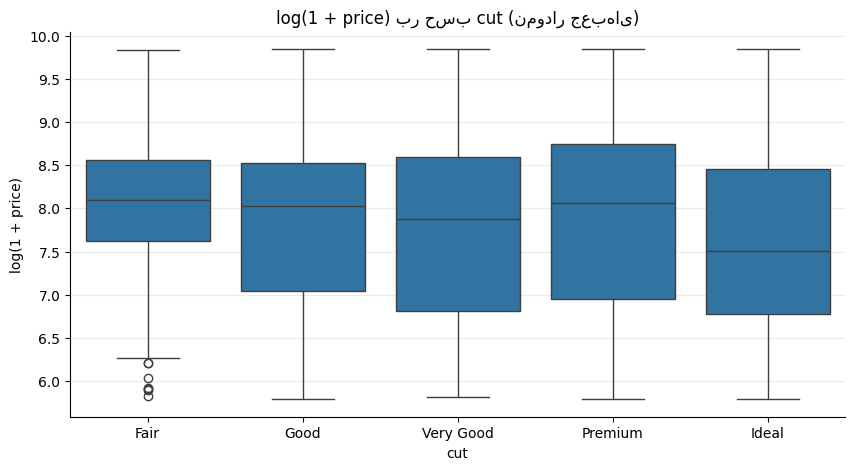

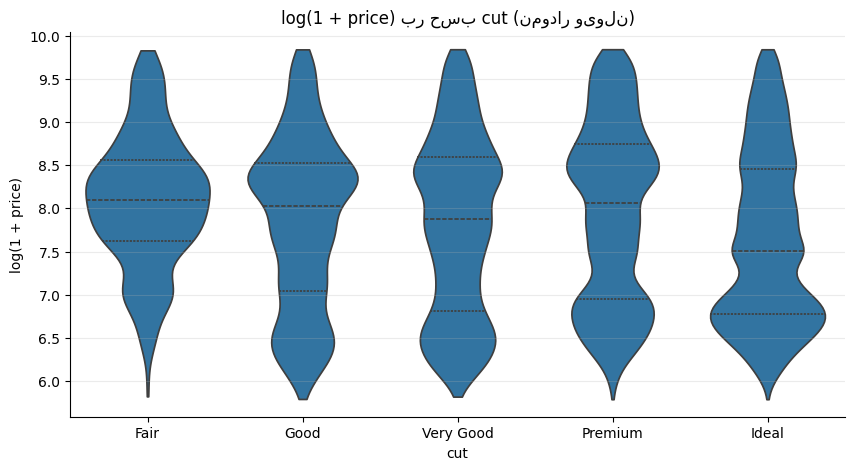

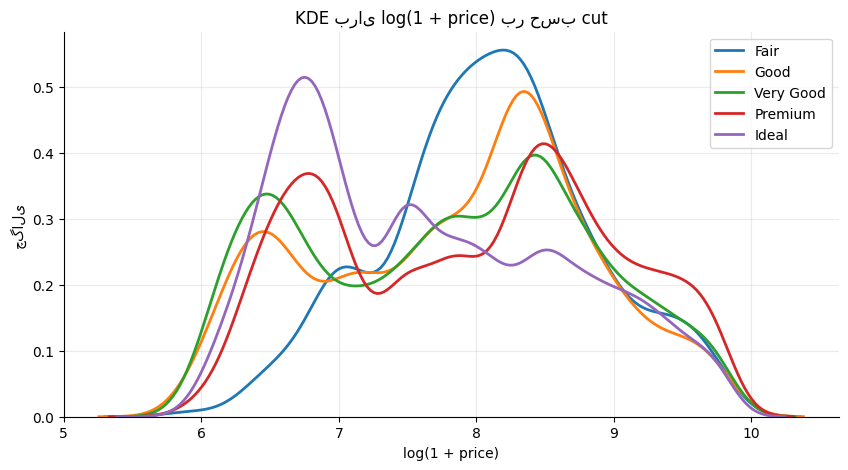

,cut,n,mean,median,std,p10,p90
0,Fair,1610,4358.757764,3282.0,3560.386612,1114.0,9133.7
1,Good,4906,3928.864452,3050.5,3681.589584,603.0,8736.0
2,Very Good,12082,3981.759891,2648.0,3935.862161,576.0,9680.9
3,Premium,13791,4584.257704,3185.0,4349.204961,709.0,11413.0
4,Ideal,21551,3457.541970,1810.0,3808.401172,652.0,9077.0


In [11]:
# مقایسه توزیع قیمت بر حسب دسته cut
diamonds2 = diamonds.copy()
diamonds2["price"] = pd.to_numeric(diamonds2["price"], errors="coerce")
diamonds2["log1p_price"] = np.log1p(diamonds2["price"])

# مرتب‌سازی دسته‌ها (در صورت وجود)
cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
if "cut" in diamonds2.columns:
    observed = [c for c in cut_order if c in diamonds2["cut"].dropna().unique()]
    if observed:
        diamonds2["cut"] = pd.Categorical(diamonds2["cut"], categories=observed, ordered=True)

# نمودار جعبه‌ای: مقایسه مقاوم میانه و پراکندگی
if "cut" in diamonds2.columns:
    fig, ax = plt.subplots(figsize=(10, 5))
    if _HAS_SEABORN:
        sns.boxplot(data=diamonds2, x="cut", y="log1p_price", ax=ax)
    else:
        groups = [diamonds2.loc[diamonds2["cut"] == c, "log1p_price"].dropna().to_numpy()
                  for c in diamonds2["cut"].cat.categories]
        ax.boxplot(groups, labels=list(diamonds2["cut"].cat.categories))
    ax.set_title("log(1 + price) بر حسب cut (نمودار جعبه‌ای)")
    ax.set_xlabel("cut")
    ax.set_ylabel("log(1 + price)")
    plt.show()

# نمودار ویولن: نمایش شکل چگالی (نیازمند seaborn)
if _HAS_SEABORN and "cut" in diamonds2.columns:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.violinplot(data=diamonds2, x="cut", y="log1p_price", ax=ax, inner="quartile", cut=0)
    ax.set_title("log(1 + price) بر حسب cut (نمودار ویولن)")
    ax.set_xlabel("cut")
    ax.set_ylabel("log(1 + price)")
    plt.show()

# KDE هم‌پوشان: مقایسه شکل توزیع
if _HAS_SEABORN and "cut" in diamonds2.columns:
    fig, ax = plt.subplots(figsize=(10, 5))
    for c in diamonds2["cut"].cat.categories:
        s = diamonds2.loc[diamonds2["cut"] == c, "log1p_price"].dropna()
        if len(s) > 10:
            sns.kdeplot(s, ax=ax, label=str(c), linewidth=2)
    ax.set_title("KDE برای log(1 + price) بر حسب cut")
    ax.set_xlabel("log(1 + price)")
    ax.set_ylabel("چگالی")
    ax.legend()
    plt.show()

# آمار خلاصه برای هر گروه
if "cut" in diamonds2.columns:
    summary = (diamonds2
               .groupby("cut")["price"]
               .agg(n="count", mean="mean", median="median", std="std",
                    p10=lambda s: np.nanpercentile(s, 10),
                    p90=lambda s: np.nanpercentile(s, 90))
               .reset_index())
    display(summary)



### ۶) توزیع‌های رده‌ای و گسسته

همه ویژگی‌های مهم پیوسته نیستند.
ویژگی‌های رده‌ای در داده‌های جدولی ML فراوان‌اند (جنسیت، منطقه، نوع محصول و ...).

برای متغیر رده‌ای $C$ با مقادیر $\{1,\ldots,K\}$، توزیع با احتمالات زیر تعریف می‌شود:
$$
p_k = \mathbb{P}(C=k), \quad k=1,\ldots,K.
$$

از داده‌ها، $p_k$ را با فراوانی نسبی برآورد می‌کنید:
$$
\hat p_k = \frac{1}{n}\sum_{i=1}^n \mathbf{1}\{C_i = k\}.
$$

نمودار میله‌ای شمارش یا نسبت، مستقیم‌ترین نمایش است.
برای دو متغیر رده‌ای، جدول توافقی و میله‌های انباشته/نسبتی وابستگی را آشکار می‌کنند.

از `drug200.csv` استفاده می‌کنیم که ستون‌های رده‌ای مانند `Sex`، `BP`، `Cholesterol` و برچسب `Drug` دارد.


In [12]:
# دیتاست ۲ (طبقه‌بندی): drug200
drug_path = "../../../Datasets/Classification/drug200.csv"
drug = read_csv_rel(drug_path)

quick_overview(drug, name="drug200")


drug200: shape=(200, 6)


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY



نوع ستون‌ها:


,dtype
Age,int64
Sex,object
BP,object
Cholesterol,object
Na_to_K,float64
Drug,object



مقدار گمشده (%):


,missing_%
Age,0.0
Sex,0.0
BP,0.0
Cholesterol,0.0
Na_to_K,0.0
Drug,0.0


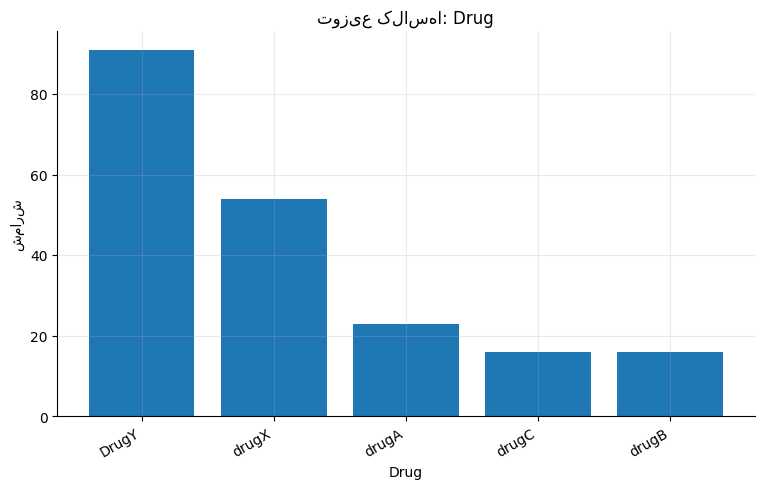

,proportion
Drug,
DrugY,0.455
drugX,0.270
drugA,0.115
drugC,0.080
drugB,0.080


Drug,DrugY,drugA,drugB,drugC,drugX
Sex,,,,,
F,0.489583,0.093750,0.062500,0.072917,0.281250
M,0.423077,0.134615,0.096154,0.086538,0.259615


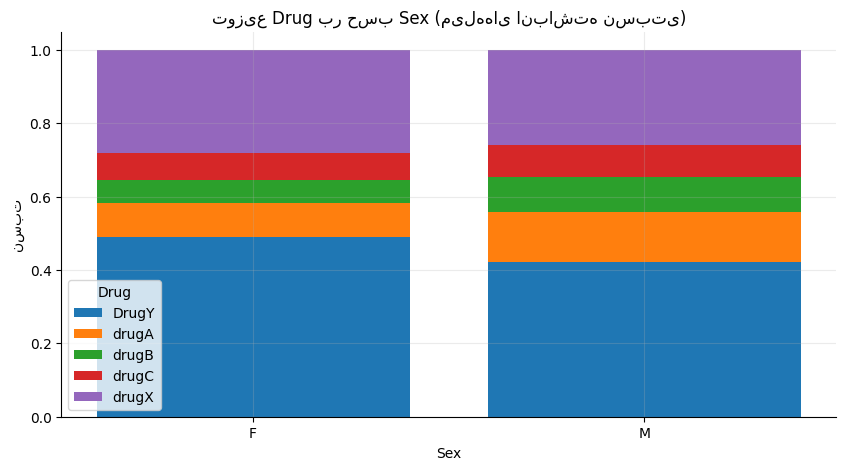

In [13]:
# توزیع برچسب هدف: Drug
fig, ax = plt.subplots()
counts = drug["Drug"].value_counts(dropna=False)
ax.bar(counts.index.astype(str), counts.values)
ax.set_title("توزیع کلاس‌ها: Drug")
ax.set_xlabel("Drug")
ax.set_ylabel("شمارش")
plt.xticks(rotation=30, ha="right")
plt.show()

# نسبت‌ها
props = counts / counts.sum()
display(props.to_frame("proportion"))

# میله‌های انباشته نسبتی: Drug به شرط Sex
if "Sex" in drug.columns:
    ct = pd.crosstab(drug["Sex"], drug["Drug"], normalize="index")
    display(ct)

    fig, ax = plt.subplots(figsize=(10, 5))
    bottom = np.zeros(ct.shape[0])
    for col in ct.columns:
        ax.bar(ct.index.astype(str), ct[col].values, bottom=bottom, label=str(col))
        bottom += ct[col].values
    ax.set_title("توزیع Drug بر حسب Sex (میله‌های انباشته نسبتی)")
    ax.set_xlabel("Sex")
    ax.set_ylabel("نسبت")
    ax.legend(title="Drug")
    plt.show()



### ۷) کمّی‌سازی عدم‌قطعیت: بازه اطمینان برای نسبت‌ها

وقتی $n$ خیلی بزرگ نیست، نسبت‌های کلاس فقط *برآورد* هستند و عدم‌قطعیت دارند.

برای حالت دودویی با شمارش $k$ از $n$، نسبت نمونه $\hat p = k/n$ است.
یک بازه اطمینان مناسب، **بازه ویلسون** است (از تقریب نرمال ساده پایدارتر):
$$
\hat p_W = \frac{\hat p + \frac{z^2}{2n}}{1 + \frac{z^2}{n}},
\qquad
\text{نیم‌پهنه} = \frac{z}{1 + \frac{z^2}{n}}
\sqrt{\frac{\hat p(1-\hat p)}{n} + \frac{z^2}{4n^2}},
$$
که در آن $z$ مقدار بحرانی نرمال استاندارد است (مثلاً $z \approx 1.96$ برای ۹۵٪).

در چندکلاسه، می‌توانید برای هر کلاس به‌صورت «کلاس در برابر غیرکلاس» بازه ویلسون حساب کنید.
برای EDA سریع، این کار معمولاً کافی است تا بفهمید اختلاف‌ها چقدر معنادار به نظر می‌رسند.


,Drug,count,proportion,CI95_low,CI95_high
0,DrugY,91,0.455,0.387481,0.524215
1,drugX,54,0.270,0.213234,0.335436
2,drugA,23,0.115,0.077863,0.166648
3,drugC,16,0.080,0.049840,0.125990
4,drugB,16,0.080,0.049840,0.125990


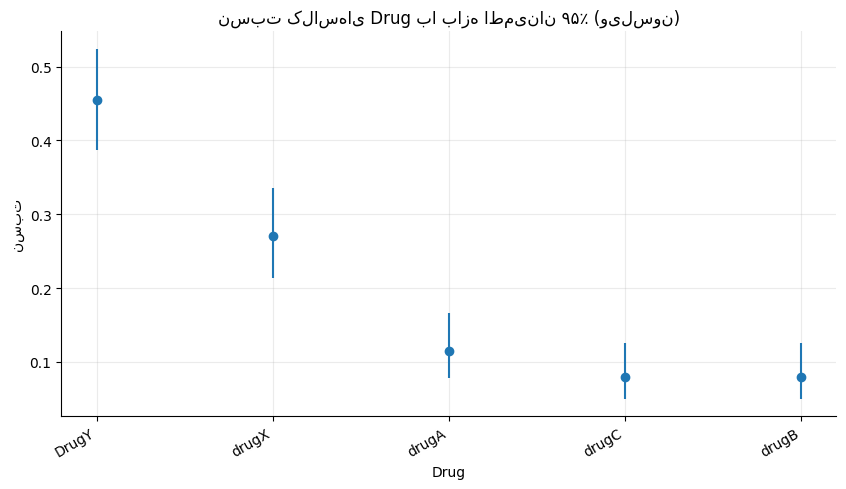

In [14]:
def wilson_interval(k: int, n: int, z: float = 1.96):
    if n == 0:
        return (np.nan, np.nan)
    phat = k / n
    denom = 1 + (z**2) / n
    center = (phat + (z**2) / (2*n)) / denom
    half = (z / denom) * np.sqrt((phat*(1-phat)/n) + (z**2)/(4*n**2))
    return (center - half, center + half)

# بازه‌های ویلسون برای نسبت هر کلاس Drug
n = len(drug)
rows = []
for cls, k in counts.items():
    lo, hi = wilson_interval(int(k), n, z=1.96)
    rows.append({"Drug": str(cls), "count": int(k), "proportion": k/n, "CI95_low": lo, "CI95_high": hi})
ci_df = pd.DataFrame(rows).sort_values("proportion", ascending=False)
display(ci_df)

fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(
    x=np.arange(len(ci_df)),
    y=ci_df["proportion"],
    yerr=[ci_df["proportion"] - ci_df["CI95_low"], ci_df["CI95_high"] - ci_df["proportion"]],
    fmt="o"
)
ax.set_xticks(np.arange(len(ci_df)))
ax.set_xticklabels(ci_df["Drug"], rotation=30, ha="right")
ax.set_title("نسبت کلاس‌های Drug با بازه اطمینان ۹۵٪ (ویلسون)")
ax.set_xlabel("Drug")
ax.set_ylabel("نسبت")
plt.show()



### ۸) توزیع‌های عددی همراه با «متغیرهای شبیه هدف» (مثال: کیفیت شراب)

در EDA برای یادگیری نظارت‌شده، معمولاً داریم:

- ویژگی‌های عددی متعدد،
- یک هدف که ممکن است گسسته یا ترتیبی باشد (مثل `quality`).

باید این موارد را مصورسازی کنید:

- توزیع‌های حاشیه‌ای ویژگی‌ها (چولگی، نقاط پرت، مقیاس),
- توزیع هدف (عدم‌توازن کلاس / نویز برچسب),
- توزیع ویژگی‌ها به شرط هدف (جداسازی، روندهای یکنواخت),
- توزیع‌های مشترک برای ویژگی‌های همبسته (سیگنال‌های چندهمخطی).

از `Wine_Quality.csv` استفاده می‌کنیم.


In [15]:
# دیتاست ۳ (هدف ترتیبی): Wine Quality
wine_path = "../../../Datasets/Classification/Wine_Quality.csv"
wine = read_csv_rel(wine_path)

quick_overview(wine, name="Wine_Quality")


Wine_Quality: shape=(4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6



نوع ستون‌ها:


,dtype
fixed acidity,float64
volatile acidity,float64
citric acid,float64
residual sugar,float64
chlorides,float64
free sulfur dioxide,float64
total sulfur dioxide,float64
density,float64
pH,float64
sulphates,float64



مقدار گمشده (%):


,missing_%
fixed acidity,0.0
volatile acidity,0.0
citric acid,0.0
residual sugar,0.0
chlorides,0.0
free sulfur dioxide,0.0
total sulfur dioxide,0.0
density,0.0
pH,0.0
sulphates,0.0


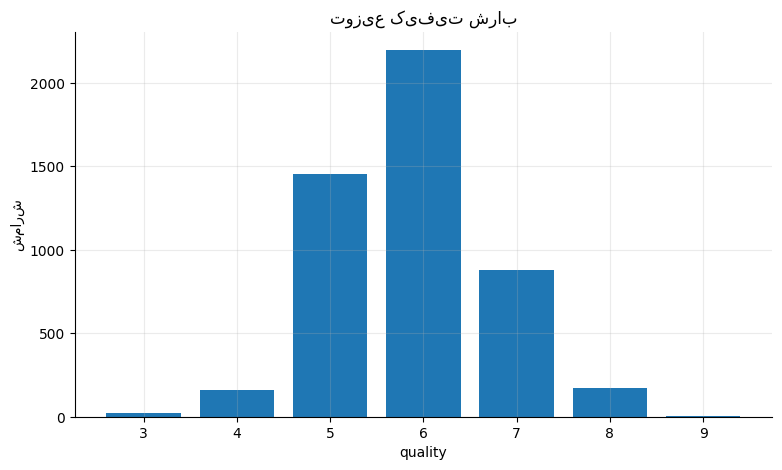

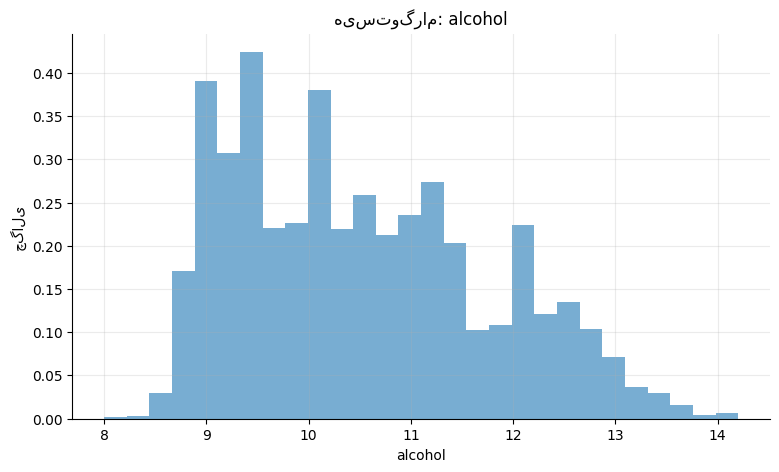

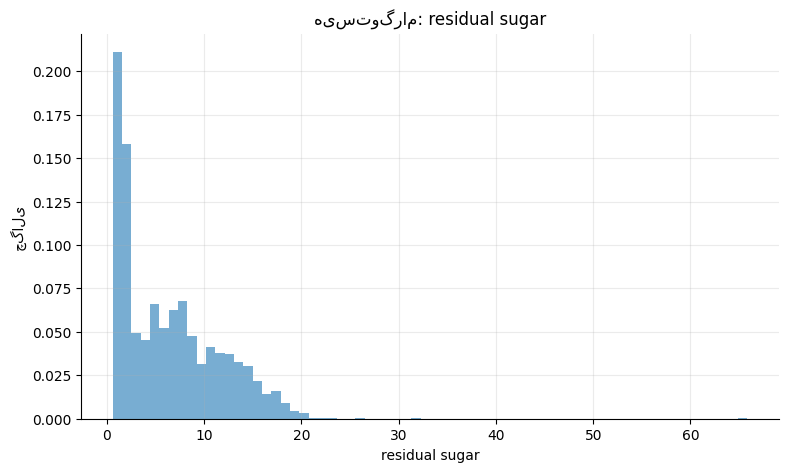

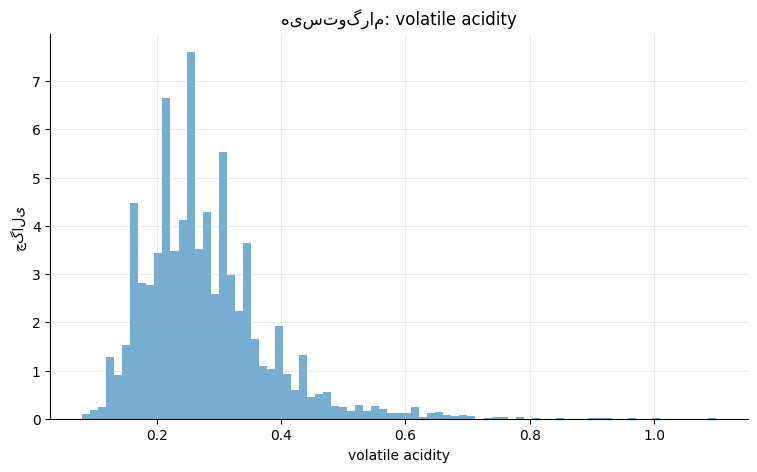

In [16]:
# توزیع هدف: quality (اغلب به‌صورت ترتیبی در نظر گرفته می‌شود)
fig, ax = plt.subplots()
q_counts = wine["quality"].value_counts().sort_index()
ax.bar(q_counts.index.astype(str), q_counts.values)
ax.set_title("توزیع کیفیت شراب")
ax.set_xlabel("quality")
ax.set_ylabel("شمارش")
plt.show()

# چند توزیع ویژگی نمونه: alcohol و residual sugar
for col in ["alcohol", "residual sugar", "volatile acidity"]:
    if col in wine.columns:
        s = pd.to_numeric(wine[col], errors="coerce").dropna()
        fig, ax = plt.subplots()
        ax.hist(s, bins=freedman_diaconis_bins(s), density=True, alpha=0.6)
        ax.set_title(f"هیستوگرام: {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("چگالی")
        plt.show()


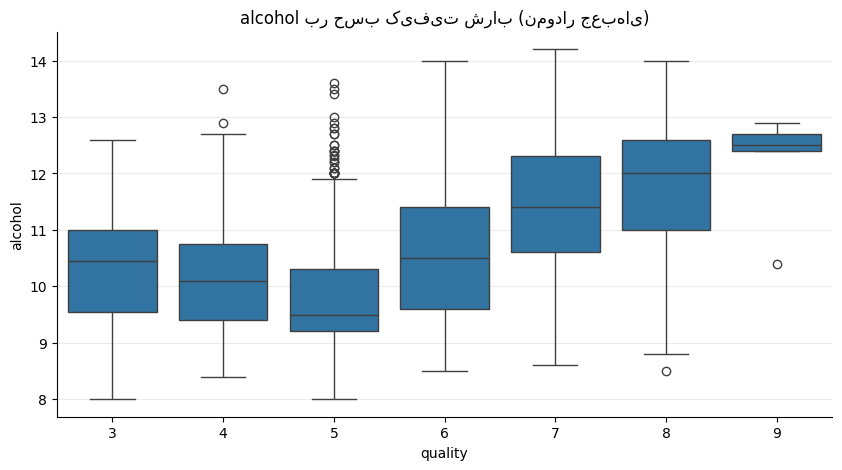

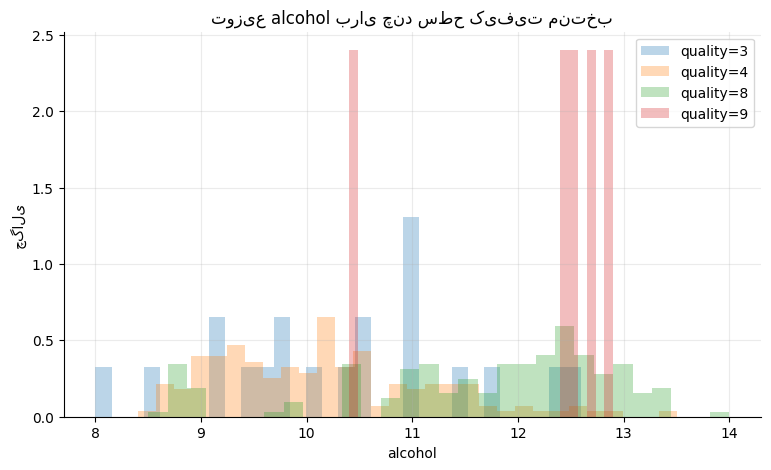

In [17]:
# توزیع شرطی: alcohol بر حسب quality
if _HAS_SEABORN and "alcohol" in wine.columns:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(data=wine, x="quality", y="alcohol", ax=ax)
    ax.set_title("alcohol بر حسب کیفیت شراب (نمودار جعبه‌ای)")
    ax.set_xlabel("quality")
    ax.set_ylabel("alcohol")
    plt.show()

# هیستوگرام‌های هم‌پوشان برای چند کیفیت انتخابی
if "alcohol" in wine.columns:
    qualities = sorted(wine["quality"].dropna().unique())
    chosen = qualities[:2] + qualities[-2:] if len(qualities) >= 4 else qualities
    series_list = [wine.loc[wine["quality"] == q, "alcohol"] for q in chosen]
    fig, ax = plt.subplots()
    overlay_hist(ax, series_list, labels=[f"quality={q}" for q in chosen],
                 bins=30, density=True, alpha=0.3)
    ax.set_title("توزیع alcohol برای چند سطح کیفیت منتخب")
    ax.set_xlabel("alcohol")
    ax.set_ylabel("چگالی")
    plt.show()



### ۹) توزیع‌های مشترک (نمایش‌های دو‌بعدی و چندبعدی)

یک توزیع تک‌متغیره ممکن است گمراه‌کننده باشد اگر ویژگی‌ها با هم تعامل داشته باشند.
دو الگوی مهم در EDA برای ML:

- **همبستگی و چندهمخطی**: اطلاعات تکراری، ضرایب ناپایدار در مدل‌های خطی.
- **ساختار غیرخطی**: خوشه‌ها، رژیم‌ها یا ناهمسان‌واریانس.

برای زوج‌های عددی–عددی:

- نمودار پراکندگی (برای $n$ کوچک/متوسط),
- Hexbin / هیستوگرام دوبعدی (برای $n$ بزرگ‌تر),
- کانتور / KDE مشترک (نیازمند فرض هموارسازی).

این‌ها را با خلاصه‌های همبستگی ترکیب کنید.


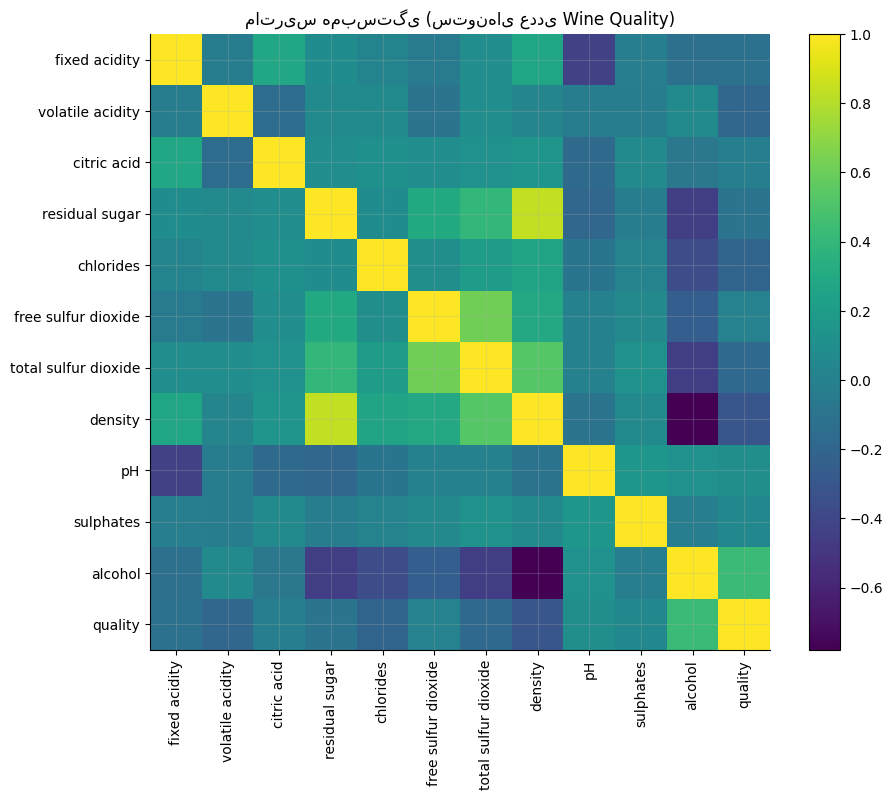

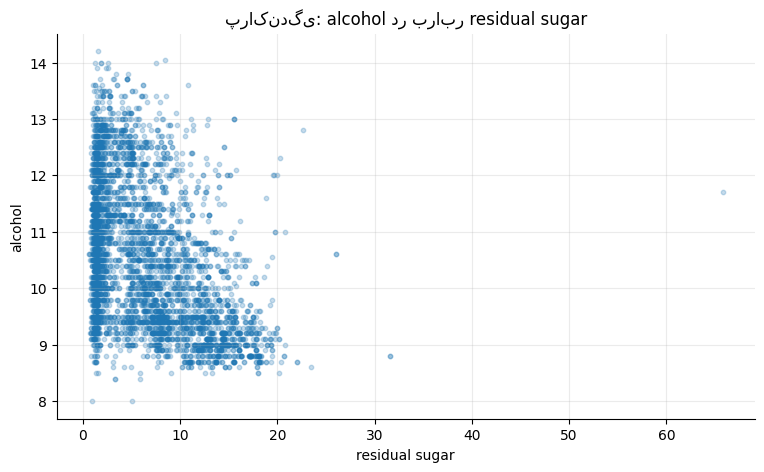

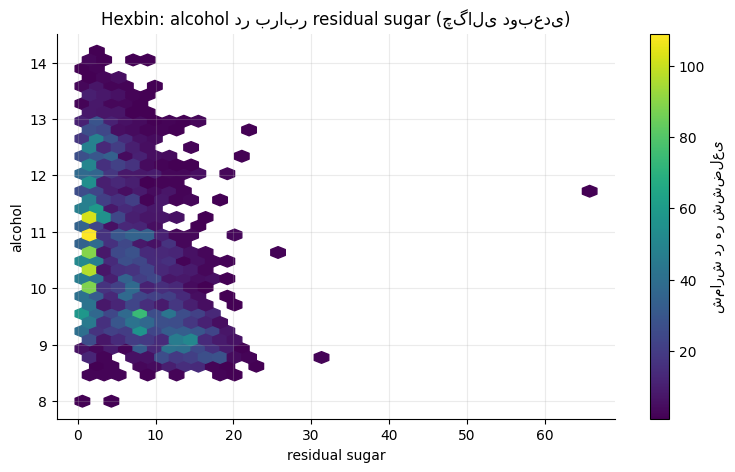

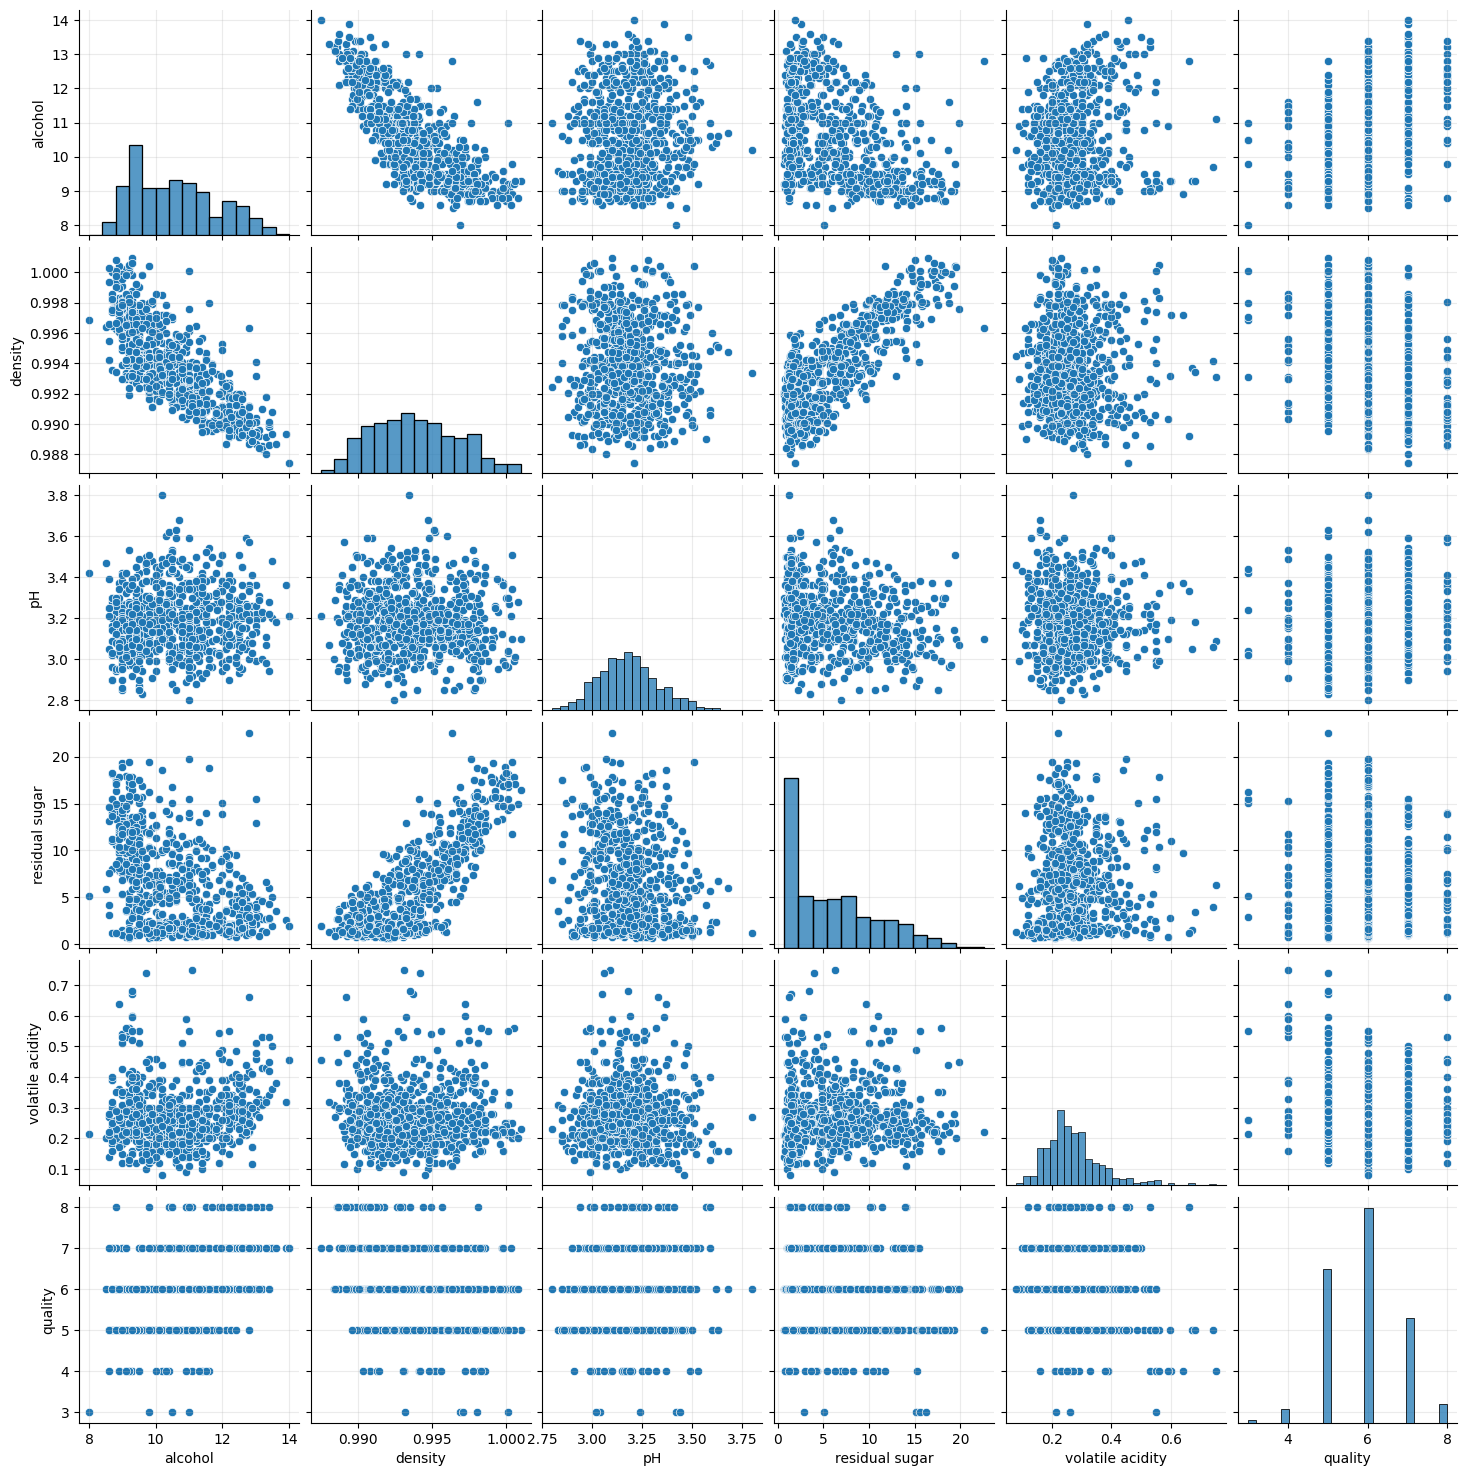

In [18]:
# نمای کلی همبستگی (ستون‌های عددی)
num_cols = wine.select_dtypes(include=[np.number]).columns
corr = wine[num_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr.values, aspect="auto")
ax.set_xticks(np.arange(len(num_cols)))
ax.set_yticks(np.arange(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=90)
ax.set_yticklabels(num_cols)
ax.set_title("ماتریس همبستگی (ستون‌های عددی Wine Quality)")
plt.colorbar(im, ax=ax)
plt.show()

# توزیع مشترک: alcohol در برابر residual sugar
if {"alcohol", "residual sugar"}.issubset(wine.columns):
    x = pd.to_numeric(wine["residual sugar"], errors="coerce")
    y = pd.to_numeric(wine["alcohol"], errors="coerce")
    m = x.notna() & y.notna()
    x = x[m].to_numpy()
    y = y[m].to_numpy()

    fig, ax = plt.subplots()
    ax.scatter(x, y, s=10, alpha=0.25)
    ax.set_title("پراکندگی: alcohol در برابر residual sugar")
    ax.set_xlabel("residual sugar")
    ax.set_ylabel("alcohol")
    plt.show()

    fig, ax = plt.subplots()
    hb = ax.hexbin(x, y, gridsize=35, mincnt=1)
    ax.set_title("Hexbin: alcohol در برابر residual sugar (چگالی دوبعدی)")
    ax.set_xlabel("residual sugar")
    ax.set_ylabel("alcohol")
    plt.colorbar(hb, ax=ax, label="شمارش در هر شش‌ضلعی")
    plt.show()

# روابط جفتی (نیازمند seaborn)
if _HAS_SEABORN:
    subset_cols = [c for c in ["alcohol", "density", "pH", "residual sugar", "volatile acidity", "quality"] if c in wine.columns]
    if len(subset_cols) >= 3:
        sns.pairplot(wine[subset_cols].dropna().sample(min(800, len(wine)), random_state=42), diag_kind="hist")



### ۱۰) تشخیص تغییر توزیع (train در برابر test و تولید)

در ML، **تغییر توزیع** یکی از رایج‌ترین دلایل افت عملکرد پس از استقرار است.

دو بررسی ساده و عملی در EDA:

1) **چک هم‌پوشانی بصری**:
   - هم‌پوشانی هیستوگرام یا KDE یک ویژگی برای دو نمونه (مثلاً train و test).
2) **فاصله/آزمون کمّی**:
   - آماره کولموگروف–اسمیرنوف (KS) برای ویژگی‌های پیوسته،
   - مقایسه‌های شبیه کای‌اسکوئر برای ویژگی‌های رده‌ای،
   - شاخص پایداری جمعیت (PSI) به‌عنوان یک معیار سرانگشتی.

این ابزارها drift را «اثبات» نمی‌کنند، ولی سریعاً سطح شک را کم یا زیاد می‌کنند.

با `diabetes.csv` این موضوع را روی یک اسپیلیت تصادفی train/test نشان می‌دهیم.


In [19]:
# دیتاست ۴ (طبقه‌بندی): diabetes
diabetes_path = "../../../Datasets/Classification/diabetes.csv"
diabetes = read_csv_rel(diabetes_path)

quick_overview(diabetes, name="diabetes")


diabetes: shape=(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic



نوع ستون‌ها:


,dtype
Pregnancies,int64
Glucose,int64
BloodPressure,int64
SkinThickness,int64
Insulin,int64
BMI,float64
DiabetesPedigreeFunction,float64
Age,int64
classification,object



مقدار گمشده (%):


,missing_%
Pregnancies,0.0
Glucose,0.0
BloodPressure,0.0
SkinThickness,0.0
Insulin,0.0
BMI,0.0
DiabetesPedigreeFunction,0.0
Age,0.0
classification,0.0


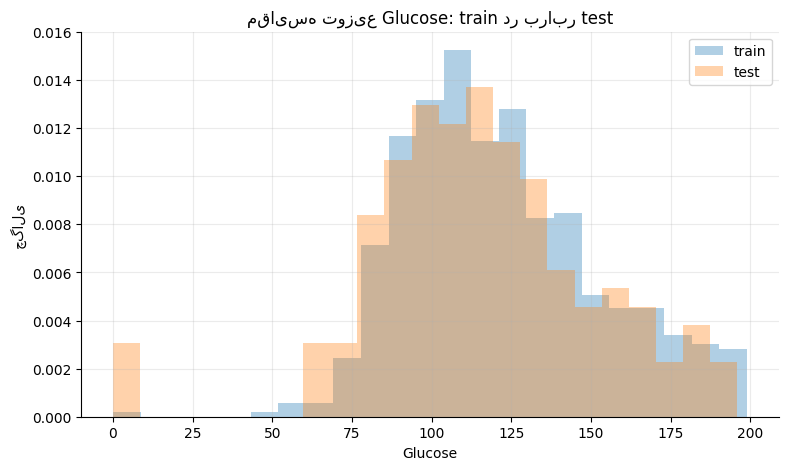

آماره KS برای Glucose (train در برابر test): 0.0774
آزمون KS در SciPy: KstestResult(statistic=np.float64(0.07735098777444055), pvalue=np.float64(0.42670665938923175), statistic_location=np.int64(94), statistic_sign=np.int8(-1))
PSI برای Glucose (train به‌عنوان expected و test به‌عنوان actual): 0.0382


In [20]:
# اسپیلیت train/test و مقایسه توزیع یک ویژگی عددی
rng = np.random.default_rng(42)
idx = np.arange(len(diabetes))
rng.shuffle(idx)

train_idx = idx[: int(0.8 * len(idx))]
test_idx = idx[int(0.8 * len(idx)) :]

train = diabetes.iloc[train_idx].copy()
test = diabetes.iloc[test_idx].copy()

feature = "Glucose" if "Glucose" in diabetes.columns else diabetes.select_dtypes(include=[np.number]).columns[0]

x_train = pd.to_numeric(train[feature], errors="coerce").dropna()
x_test = pd.to_numeric(test[feature], errors="coerce").dropna()

fig, ax = plt.subplots()
bins = freedman_diaconis_bins(pd.concat([x_train, x_test], ignore_index=True))
overlay_hist(ax, [x_train, x_test], ["train", "test"], bins=bins, density=True, alpha=0.35)
ax.set_title(f"مقایسه توزیع {feature}: train در برابر test")
ax.set_xlabel(feature)
ax.set_ylabel("چگالی")
plt.show()

# آماره KS (برای پیوسته)
def ks_statistic(a: np.ndarray, b: np.ndarray) -> float:
    a = np.sort(a[np.isfinite(a)])
    b = np.sort(b[np.isfinite(b)])
    na, nb = len(a), len(b)
    if na == 0 or nb == 0:
        return np.nan
    i = j = 0
    cdf_a = cdf_b = 0.0
    d = 0.0
    while i < na and j < nb:
        if a[i] <= b[j]:
            i += 1
            cdf_a = i / na
        else:
            j += 1
            cdf_b = j / nb
        d = max(d, abs(cdf_a - cdf_b))
    while i < na:
        i += 1
        cdf_a = i / na
        d = max(d, abs(cdf_a - cdf_b))
    while j < nb:
        j += 1
        cdf_b = j / nb
        d = max(d, abs(cdf_a - cdf_b))
    return d

ks_d = ks_statistic(x_train.to_numpy(), x_test.to_numpy())
print(f"آماره KS برای {feature} (train در برابر test): {ks_d:.4f}")

if _HAS_SCIPY:
    ks_res = stats.ks_2samp(x_train, x_test)
    print("آزمون KS در SciPy:", ks_res)

# PSI (Population Stability Index)
def population_stability_index(expected: np.ndarray, actual: np.ndarray, bins: int = 10) -> float:
    expected = expected[np.isfinite(expected)]
    actual = actual[np.isfinite(actual)]
    if expected.size == 0 or actual.size == 0:
        return np.nan
    quantiles = np.linspace(0, 1, bins + 1)
    edges = np.unique(np.quantile(expected, quantiles))
    if edges.size < 3:
        return 0.0
    exp_counts, _ = np.histogram(expected, bins=edges)
    act_counts, _ = np.histogram(actual, bins=edges)

    exp_perc = exp_counts / exp_counts.sum()
    act_perc = act_counts / act_counts.sum()

    eps = 1e-6
    exp_perc = np.clip(exp_perc, eps, 1)
    act_perc = np.clip(act_perc, eps, 1)

    psi = np.sum((act_perc - exp_perc) * np.log(act_perc / exp_perc))
    return float(psi)

psi_val = population_stability_index(x_train.to_numpy(), x_test.to_numpy(), bins=10)
print(f"PSI برای {feature} (train به‌عنوان expected و test به‌عنوان actual): {psi_val:.4f}")



### ۱۱) تبدیل‌ها برای مصورسازی (و برای مدل‌سازی)

گاهی شکل توزیع در مقیاس خام خوانا نیست، اما با یک تبدیل یکنواخت قابل تفسیر می‌شود.

الگوهای رایج:

- **متغیرهای مثبت و دنباله‌سنگین** (قیمت، درآمد، شمارش):
  - تبدیل لگاریتمی: $y = \log(1+x)$
- **تغییرپذیری ضربی**:
  - لگاریتم اغلب واریانس را پایدارتر می‌کند.
- **متغیرهای کراندار** (احتمال در $[0,1]$):
  - تبدیل logit: $y = \log\frac{p}{1-p}$ (با ۰/۱ احتیاط کنید).
- **تبدیل‌های توانی** (Box–Cox، Yeo–Johnson):
  - می‌توانند چولگی را کم کنند، اما برای تفسیر باید با احتیاط به کار روند.

اصل کلیدی:

> تبدیل یکنواخت رتبه را حفظ می‌کند اما فاصله را تغییر می‌دهد.

پس برای فهم «شکل»، تبدیل‌ها بسیار مفیدند.
برای مدل‌سازی نیز باید توجه کنید تبدیل چه معنایی برای تابع خطا و تفسیر خطا دارد.

مثال: اگر $\log(1 + y)$ را با خطای مربعی مدل کنید، عملاً خطاهای نسبی را بیشتر از خطاهای مطلق جریمه می‌کنید.


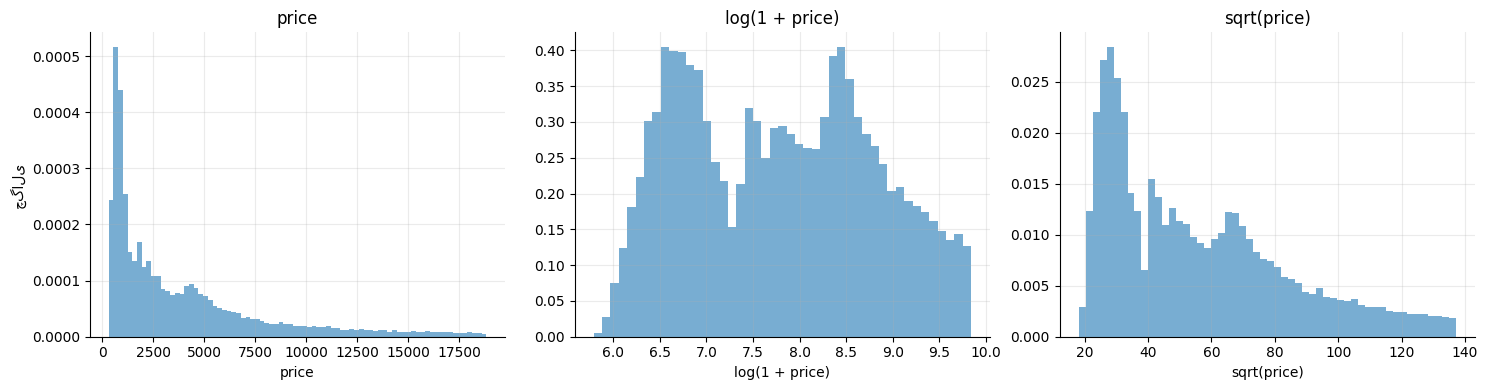

چولگی:
  price:        1.618
  log1p(price): 0.116
  sqrt(price):  0.844


In [21]:
# نشان دادن اثر تبدیل روی چولگی: price، log1p(price)، و sqrt(price)
price_arr = price.to_numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(price_arr, bins=freedman_diaconis_bins(price), density=True, alpha=0.6)
axes[0].set_title("price")
axes[0].set_xlabel("price")
axes[0].set_ylabel("چگالی")

axes[1].hist(np.log1p(price_arr), bins=freedman_diaconis_bins(log_price), density=True, alpha=0.6)
axes[1].set_title("log(1 + price)")
axes[1].set_xlabel("log(1 + price)")

axes[2].hist(np.sqrt(price_arr), bins=freedman_diaconis_bins(np.sqrt(price_arr)), density=True, alpha=0.6)
axes[2].set_title("sqrt(price)")
axes[2].set_xlabel("sqrt(price)")

plt.tight_layout()
plt.show()

# برآورد ساده چولگی (Fisher-Pearson) بدون وابستگی اضافی
def skewness(x: np.ndarray) -> float:
    x = x[np.isfinite(x)]
    n = x.size
    if n < 3:
        return np.nan
    m = x.mean()
    s = x.std(ddof=0)
    if s == 0:
        return 0.0
    return float(np.mean(((x - m) / s) ** 3))

print("چولگی:")
print(f"  price:        {skewness(price_arr):.3f}")
print(f"  log1p(price): {skewness(np.log1p(price_arr)):.3f}")
print(f"  sqrt(price):  {skewness(np.sqrt(price_arr)):.3f}")



### ۱۲) نقاط پرت: مصورسازی و خلاصه‌های مقاوم

نقطه پرت می‌تواند:

- **مشکل کیفیت داده** باشد (خطای اندازه‌گیری، اختلاف واحد),
- **رویداد نادر اما معتبر** باشد (رفتار دنباله‌ای که باید مدل شود),
- **سیگنال زیرجمعیت** باشد (یک سگمنت پنهان).

قبل از حذف نقاط پرت، باید آن‌ها را ببینید و منشأشان را بررسی کنید.

دو ابزار مقاوم و سریع:

- **نمودار جعبه‌ای** بر اساس چارک‌ها و IQR.
  - یک قاعده رایج: نقاط خارج از بازه $[Q_{0.25} - 1.5\,\text{IQR},\ Q_{0.75} + 1.5\,\text{IQR}]$ پرت شمرده می‌شوند.
- **انحراف مطلق میانه** (MAD):
  $$
  \text{MAD} = \text{median}(|x_i - \text{median}(x)|).
  $$
  یک z-score مقاوم:
  $$
  z_i^{\text{rob}} = \frac{x_i - \text{median}(x)}{1.4826 \cdot \text{MAD}},
  $$
  که ضریب $1.4826$ سازگاری با نرمال را فراهم می‌کند.

خلاصه‌های مقاوم کمک می‌کنند چند مقدار افراطی، برداشت شما را تسلط ندهند.


residual sugar: n=4898, تعداد پرت‌ها با قاعده IQR = 7 (0.14%)


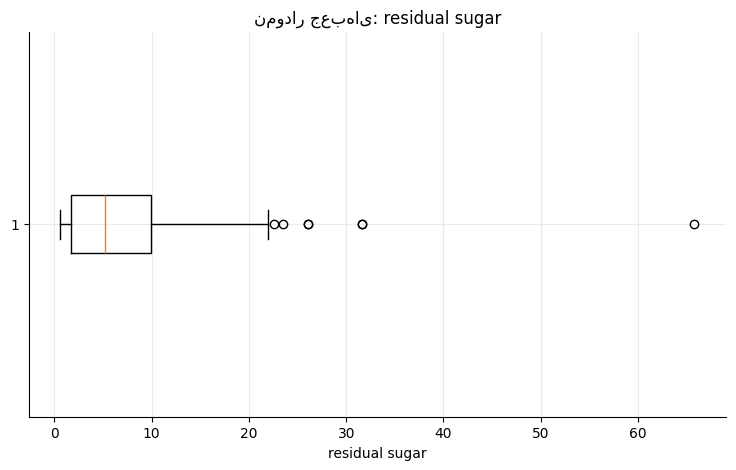

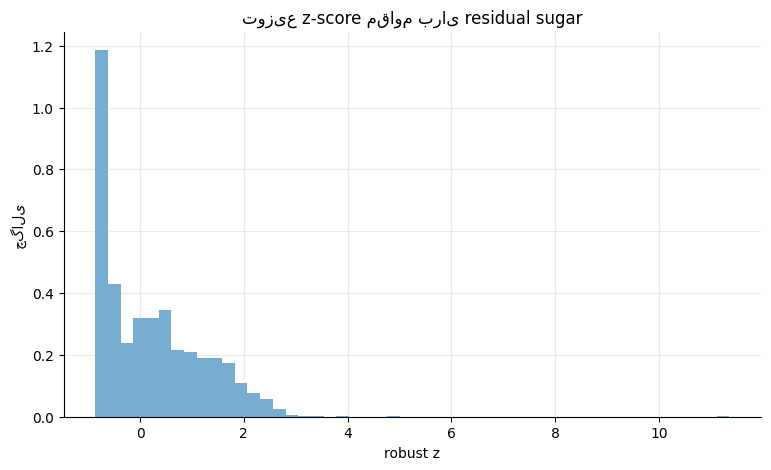

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
2781,7.8,0.965,0.60,65.80,0.074,8.0,160.0,1.03898,3.39,0.69,11.7,6
1663,7.9,0.330,0.28,31.60,0.053,35.0,176.0,1.01030,3.15,0.38,8.8,6
1653,7.9,0.330,0.28,31.60,0.053,35.0,176.0,1.01030,3.15,0.38,8.8,6
3619,6.8,0.450,0.28,26.05,0.031,27.0,122.0,1.00295,3.06,0.42,10.6,6
3623,6.8,0.450,0.28,26.05,0.031,27.0,122.0,1.00295,3.06,0.42,10.6,6
1608,6.9,0.270,0.49,23.50,0.057,59.0,235.0,1.00240,2.98,0.47,8.6,5
4480,5.9,0.220,0.45,22.60,0.120,55.0,122.0,0.99636,3.10,0.35,12.8,5
191,6.8,0.280,0.40,22.00,0.048,48.0,167.0,1.00100,2.93,0.50,8.7,5
182,6.8,0.280,0.40,22.00,0.048,48.0,167.0,1.00100,2.93,0.50,8.7,5
444,6.9,0.240,0.36,20.80,0.031,40.0,139.0,0.99750,3.20,0.33,11.0,6


In [22]:
# مثال بررسی نقطه پرت: residual sugar در Wine (معمولاً چوله با مقادیر افراطی)
col = "residual sugar" if "residual sugar" in wine.columns else wine.select_dtypes(include=[np.number]).columns[0]
x = pd.to_numeric(wine[col], errors="coerce").dropna()

q1, q3 = np.percentile(x, [25, 75])
iqr = q3 - q1
lo = q1 - 1.5 * iqr
hi = q3 + 1.5 * iqr

outliers = x[(x < lo) | (x > hi)]
print(f"{col}: n={len(x)}, تعداد پرت‌ها با قاعده IQR = {len(outliers)} ({len(outliers)/len(x):.2%})")

fig, ax = plt.subplots()
ax.boxplot(x.to_numpy(), vert=False)
ax.set_title(f"نمودار جعبه‌ای: {col}")
ax.set_xlabel(col)
plt.show()

# z-score مقاوم با MAD
med = np.median(x)
mad = np.median(np.abs(x - med))
robust_sigma = 1.4826 * mad if mad > 0 else np.std(x)
z_rob = (x - med) / (robust_sigma if robust_sigma > 0 else 1.0)

fig, ax = plt.subplots()
ax.hist(z_rob, bins=50, density=True, alpha=0.6)
ax.set_title(f"توزیع z-score مقاوم برای {col}")
ax.set_xlabel("robust z")
ax.set_ylabel("چگالی")
plt.show()

# نمایش ردیف‌های افراطی (بر حسب |z|)
extreme_idx = np.argsort(np.abs(z_rob.to_numpy()))[::-1][:10]
display(wine.loc[x.index[extreme_idx]].head(10))



### ۱۴) خطاهای رایج در مصورسازی توزیع‌ها

حتی افراد باتجربه هم ممکن است نمودارهای توزیع را اشتباه تفسیر کنند.
برخی خطاهای رایج و راه‌حل‌ها:

**خطای A — اشتباه گرفتن شمارش با چگالی**

هیستوگرام می‌تواند نشان دهد:

- **شمارش**: ارتفاع میله‌ها (تقریباً) به $n$ جمع می‌شود،
- **چگالی**: مساحت کل (تقریباً) ۱ است.

برای مقایسه گروه‌هایی با اندازه نمونه متفاوت، معمولاً چگالی مناسب‌تر است.
اگر حجم مطلق برایتان مهم است، شمارش هم مفید است.

**خطای B — پنهان کردن چندقله‌ای بودن با هموارسازی زیاد**

پهنای باند بزرگ در KDE می‌تواند چند قله را به یک قله تبدیل کند.
اگر به mixture یا سگمنت مشکوک هستید، پهنای باند را کم کنید و با هیستوگرام مقایسه کنید.

**خطای C — اثرات مرز بین‌ها**

جابجایی مرز بین‌ها می‌تواند «داستان» را عوض کند.
برای اطمینان، چند تنظیم مختلف برای بین‌ها را امتحان کنید.

**خطای D — استفاده از مقیاس خام وقتی مقیاس لگاریتمی لازم است**

برای متغیرهای دنباله‌سنگین، در مقیاس خام همه‌چیز نزدیک صفر دیده می‌شود.
راه‌حل‌ها:
- لگاریتم گرفتن از مقدار،
- محور لگاریتمی (اگر مقادیر کاملاً مثبت‌اند).

**خطای E — نادیده گرفتن گسسته بودن/دانه‌بندی اندازه‌گیری**

اگر داده‌ها صحیح/شمارشی باشند یا رُند شده باشند، KDE می‌تواند گمراه‌کننده شود.
از نمودار میله‌ای یا هیستوگرام با بین‌های هم‌تراز با اعداد صحیح استفاده کنید.

**خطای F — نتیجه‌گیری از نمونه‌های خیلی کوچک**

$n$ کوچک شکل‌های بسیار ناپایدار تولید می‌کند.
در این حالت ECDF و نمایش عدم‌قطعیت (مثلاً بوت‌استرپ) کمک می‌کند.

در عمل، باید نتیجه‌گیری شما نسبت به انتخاب‌های مصورسازی *مقاوم* باشد.


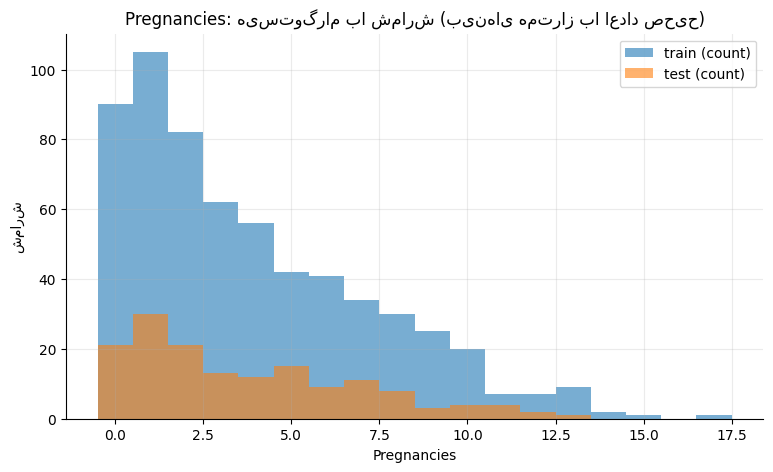

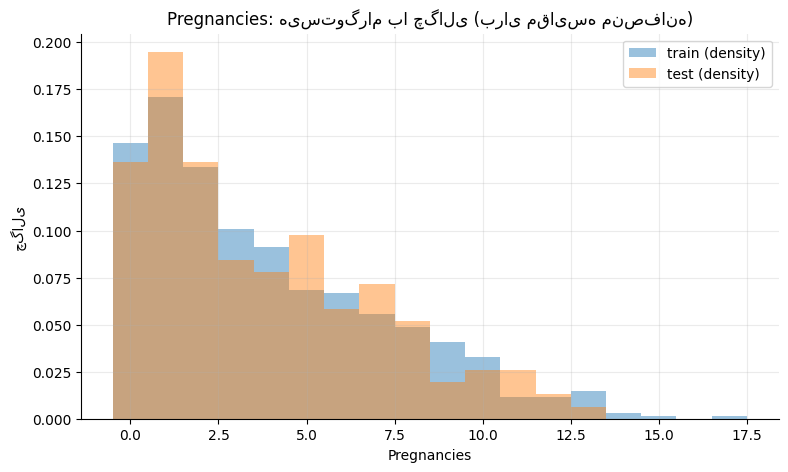

In [23]:
# نمایش تفاوت شمارش و چگالی + مثال ویژگی گسسته

# مثال: Pregnancies یک ویژگی صحیح در دیتاست diabetes است
if "Pregnancies" in diabetes.columns:
    preg_train = pd.to_numeric(train["Pregnancies"], errors="coerce").dropna().astype(int)
    preg_test = pd.to_numeric(test["Pregnancies"], errors="coerce").dropna().astype(int)

    # هیستوگرام بر مبنای شمارش
    fig, ax = plt.subplots()
    bins = np.arange(preg_train.min(), preg_train.max() + 2) - 0.5
    ax.hist(preg_train, bins=bins, alpha=0.6, label="train (count)")
    ax.hist(preg_test, bins=bins, alpha=0.6, label="test (count)")
    ax.set_title("Pregnancies: هیستوگرام با شمارش (بین‌های هم‌تراز با اعداد صحیح)")
    ax.set_xlabel("Pregnancies")
    ax.set_ylabel("شمارش")
    ax.legend()
    plt.show()

    # هیستوگرام بر مبنای چگالی
    fig, ax = plt.subplots()
    ax.hist(preg_train, bins=bins, density=True, alpha=0.45, label="train (density)")
    ax.hist(preg_test, bins=bins, density=True, alpha=0.45, label="test (density)")
    ax.set_title("Pregnancies: هیستوگرام با چگالی (برای مقایسه منصفانه)")
    ax.set_xlabel("Pregnancies")
    ax.set_ylabel("چگالی")
    ax.legend()
    plt.show()



### ۱۳) چک‌لیست عملی برای «مصورسازی توزیع‌ها» در EDA

یک روند قابل‌اعتماد برای دیتاست جدید:

1) **از توزیع‌های حاشیه‌ای شروع کنید**
   - برای هر ویژگی عددی: هیستوگرام + (اختیاری) KDE + آمار خلاصه.
   - برای هر ویژگی رده‌ای: شمارش + نسبت.

2) **مقیاس و دنباله‌ها را بررسی کنید**
   - آیا اختلاف چند مرتبه بزرگی دارید؟ مقیاس لگاریتمی را امتحان کنید.
   - آیا چند مقدار افراطی واریانس را کنترل می‌کنند؟ خلاصه‌های مقاوم به کار ببرید.

3) **توزیع‌های شرطی را مقایسه کنید**
   - بر اساس برچسب هدف یا سگمنت‌های مهم (منطقه، نوع محصول و ...).
   - هم‌پوشانی، جداسازی و چندقله‌ای بودن را ببینید.

4) **برای زوج‌های کلیدی ساختار مشترک را ببینید**
   - همبستگی می‌تواند مدل‌های خطی را ناپایدار کند.
   - الگوهای غیرخطی ممکن است مدل‌های درختی یا مهندسی ویژگی را پیشنهاد دهند.

5) **سازگاری اسپیلیت‌ها را بررسی کنید**
   - توزیع‌ها را بین train/validation/test هم‌پوشان کنید.
   - با KS/PSI اولویت بررسی عمیق‌تر را تعیین کنید.

یادآوری: مصورسازی یک قدم یک‌باره نیست؛ یک روند تکرارشونده است.
هر نمودار، فرضیه‌هایی می‌سازد که با نمودارهای بعدی آزمون می‌کنید.

---

### تمرین‌ها

۱) با دیتاست `diabetes`:
   - سه ستون عددی انتخاب کنید،
   - توزیع آن‌ها را (هیستوگرام + ECDF) رسم کنید،
   - برای یکی از ستون‌ها (اگر همه مقادیر مثبت است) تبدیل log را امتحان کنید،
   - ۲ تا ۳ جمله درباره یافته‌ها بنویسید.

۲) با `drug200`:
   - توزیع `BP` و `Cholesterol` را رسم کنید،
   - توزیع نسبتی `Drug` به شرط `BP` را محاسبه و رسم کنید،
   - بگویید آیا عدم‌توازن کلاس وجود دارد یا نه.

۳) با `Wine_Quality`:
   - دو ویژگی عددی انتخاب کنید و hexbin بکشید،
   - همبستگی‌ها را محاسبه کنید و یک زوج با همبستگی بالا پیدا کنید،
   - حدس بزنید چندهمخطی چه اثری بر یک مدل خطی دارد.

اگر این تمرین‌ها را انجام دهید، می‌توانید فاز «توزیع» در EDA داده‌های جدولی را با اطمینان اجرا کنید.
